## Trying out a linear model: 

Author: Alexandru Papiu ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
 
If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


There have been a few [great](https://www.kaggle.com/comartel/house-prices-advanced-regression-techniques/house-price-xgboost-starter/run/348739)  [scripts](https://www.kaggle.com/zoupet/house-prices-advanced-regression-techniques/xgboost-10-kfolds-with-scikit-learn/run/357561) on [xgboost](https://www.kaggle.com/tadepalli/house-prices-advanced-regression-techniques/xgboost-with-n-trees-autostop-0-12638/run/353049) already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [181]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [182]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [183]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [184]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [185]:
all_data.shape,train.shape,test.shape

((2919, 79), (1460, 81), (1459, 80))

###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f190c6d26a0>,
      dtype=object)

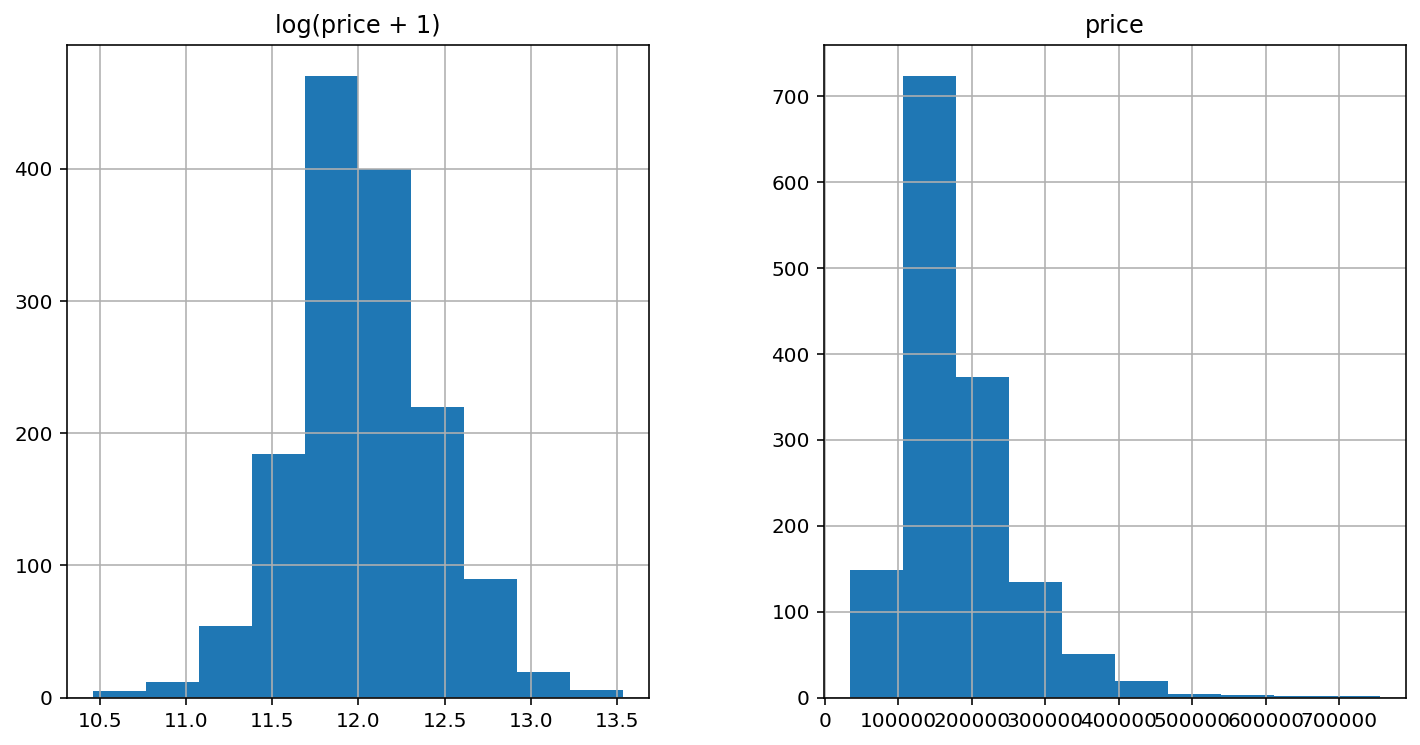

In [186]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [187]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats.shape,numeric_feats

((36,),
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'],
       dtype='object'))

In [188]:

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats.shape,skewed_feats

((36,), MSSubClass        1.406210
 LotFrontage       2.160866
 LotArea          12.195142
 OverallQual       0.216721
 OverallCond       0.692355
 YearBuilt        -0.612831
 YearRemodAdd     -0.503044
 MasVnrArea        2.666326
 BsmtFinSF1        1.683771
 BsmtFinSF2        4.250888
 BsmtUnfSF         0.919323
 TotalBsmtSF       1.522688
 1stFlrSF          1.375342
 2ndFlrSF          0.812194
 LowQualFinSF      9.002080
 GrLivArea         1.365156
 BsmtFullBath      0.595454
 BsmtHalfBath      4.099186
 FullBath          0.036524
 HalfBath          0.675203
 BedroomAbvGr      0.211572
 KitchenAbvGr      4.483784
 TotRmsAbvGrd      0.675646
 Fireplaces        0.648898
 GarageYrBlt      -0.648708
 GarageCars       -0.342197
 GarageArea        0.179796
 WoodDeckSF        1.539792
 OpenPorchSF       2.361912
 EnclosedPorch     3.086696
 3SsnPorch        10.293752
 ScreenPorch       4.117977
 PoolArea         14.813135
 MiscVal          24.451640
 MoSold            0.211835
 YrSold      

In [189]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats.shape,skewed_feats

((21,), MSSubClass        1.406210
 LotFrontage       2.160866
 LotArea          12.195142
 MasVnrArea        2.666326
 BsmtFinSF1        1.683771
 BsmtFinSF2        4.250888
 BsmtUnfSF         0.919323
 TotalBsmtSF       1.522688
 1stFlrSF          1.375342
 2ndFlrSF          0.812194
 LowQualFinSF      9.002080
 GrLivArea         1.365156
 BsmtHalfBath      4.099186
 KitchenAbvGr      4.483784
 WoodDeckSF        1.539792
 OpenPorchSF       2.361912
 EnclosedPorch     3.086696
 3SsnPorch        10.293752
 ScreenPorch       4.117977
 PoolArea         14.813135
 MiscVal          24.451640
 dtype: float64)

In [190]:
skewed_feats = skewed_feats.index
skewed_feats.shape,skewed_feats

((21,),
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal'],
       dtype='object'))

In [191]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])


/home/wb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [192]:
skewed_feats2 = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats2.shape,skewed_feats2

((36,), MSSubClass        0.245157
 LotFrontage      -0.856571
 LotArea          -0.504751
 OverallQual       0.197110
 OverallCond       0.570312
 YearBuilt        -0.599806
 YearRemodAdd     -0.451020
 MasVnrArea        0.524008
 BsmtFinSF1       -0.617645
 BsmtFinSF2        2.461871
 BsmtUnfSF        -2.158626
 TotalBsmtSF      -4.980783
 1stFlrSF          0.064828
 2ndFlrSF          0.305049
 LowQualFinSF      8.557690
 GrLivArea         0.013188
 BsmtFullBath      0.623741
 BsmtHalfBath      3.773208
 FullBath          0.167606
 HalfBath          0.694566
 BedroomAbvGr      0.326324
 KitchenAbvGr      3.520351
 TotRmsAbvGrd      0.758367
 Fireplaces        0.733495
 GarageYrBlt      -0.381942
 GarageCars       -0.218260
 GarageArea        0.241176
 WoodDeckSF        0.158033
 OpenPorchSF      -0.041797
 EnclosedPorch     1.961081
 3SsnPorch         8.825256
 ScreenPorch       2.945905
 PoolArea         14.998335
 MiscVal           5.213984
 MoSold            0.195884
 YrSold      

In [193]:
all_data.loc[:,'BsmtQual'] = all_data.loc[:,'BsmtQual'].fillna('No')
all_data.loc[:,'BsmtCond'] = all_data.loc[:,'BsmtCond'].fillna('No')

In [194]:
all_data = pd.get_dummies(all_data)

In [195]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [196]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

###Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [197]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [198]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [199]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [200]:
cv_ridge.plot()

AttributeError: 'list' object has no attribute 'plot'

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'rmse')

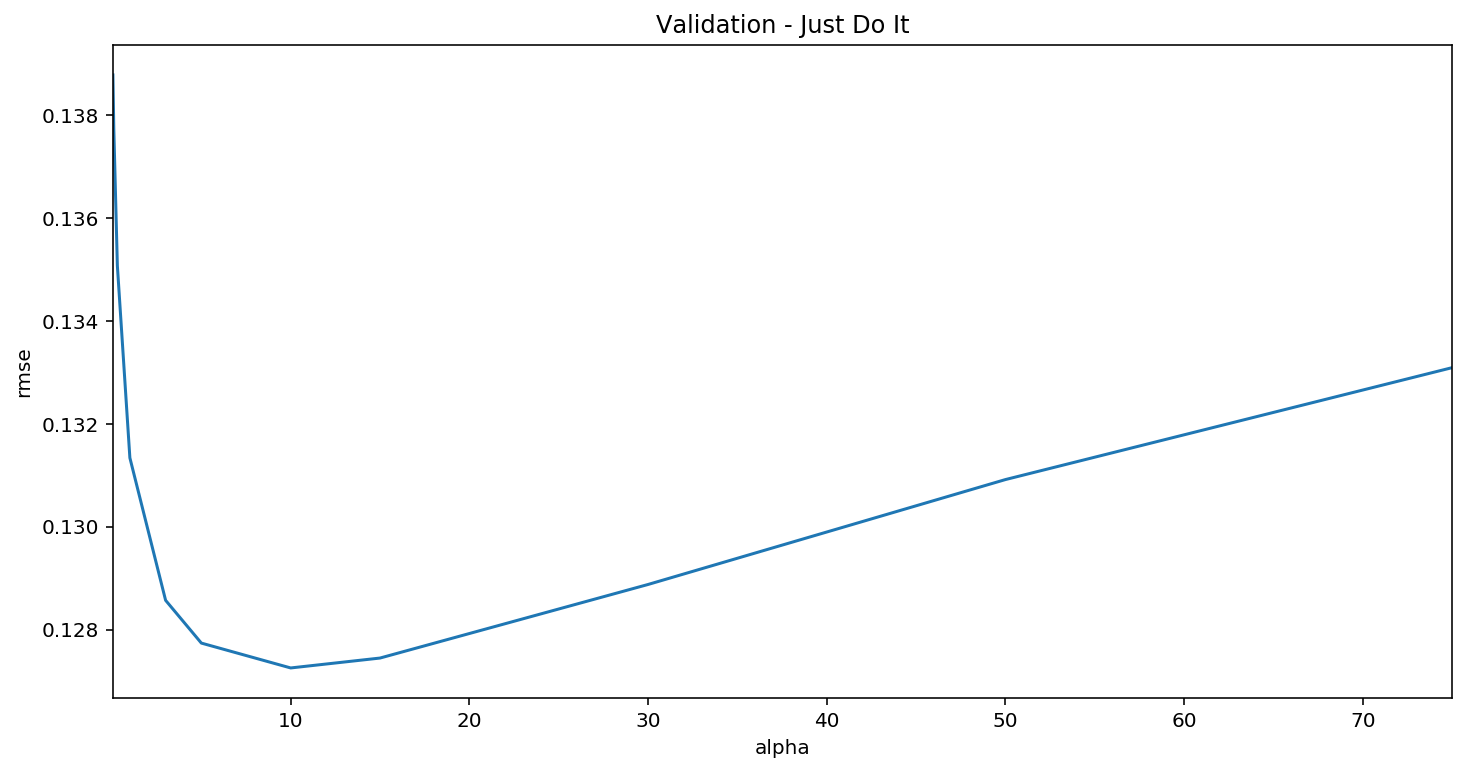

In [201]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [202]:
cv_ridge.min()

0.12725372685508798

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [124]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

/home/wb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [125]:
rmse_cv(model_lasso).mean()

/home/wb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/wb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/wb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/wb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

0.12314421090977437

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [126]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [127]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [128]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

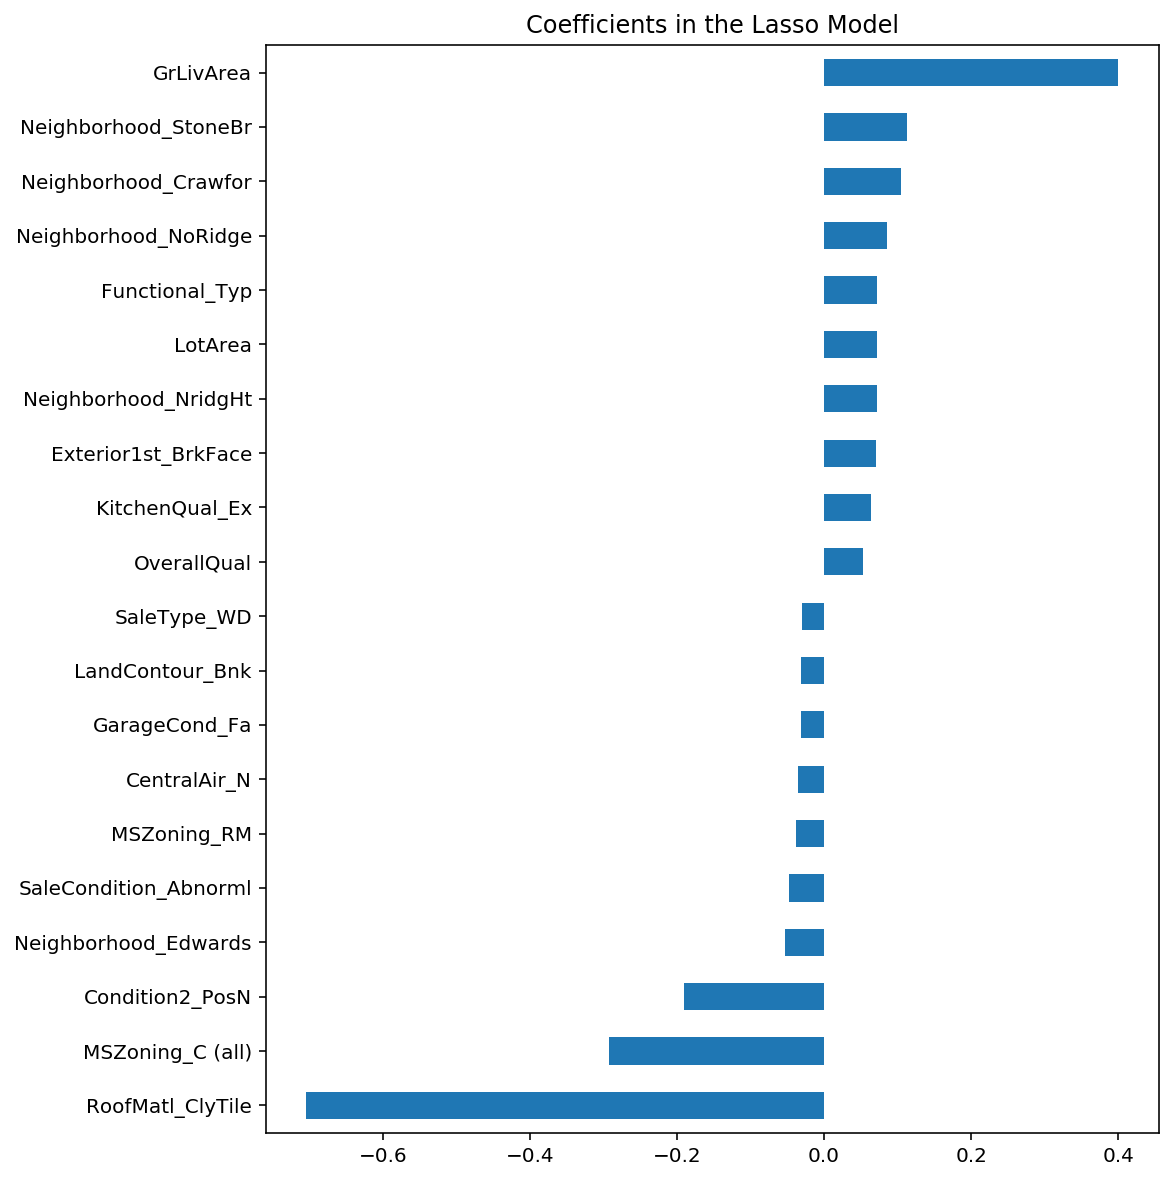

In [129]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

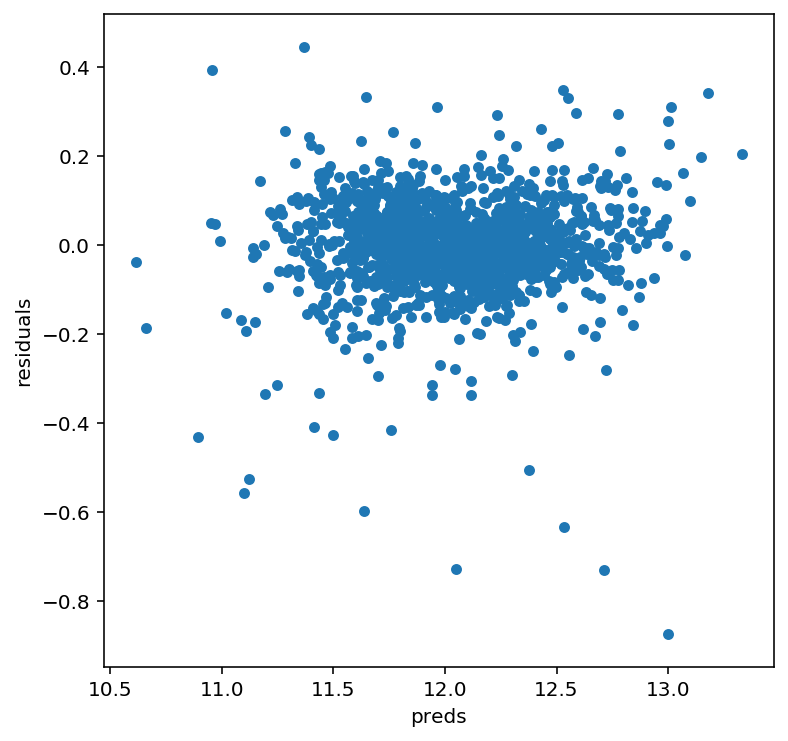

In [130]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [131]:
import xgboost as xgb

In [132]:

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

/home/wb/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wb/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


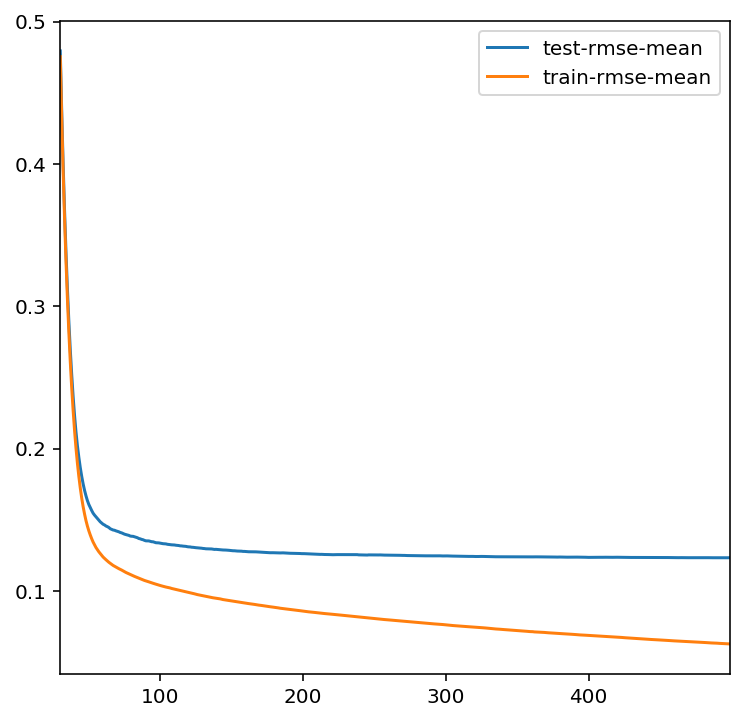

In [133]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [26]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

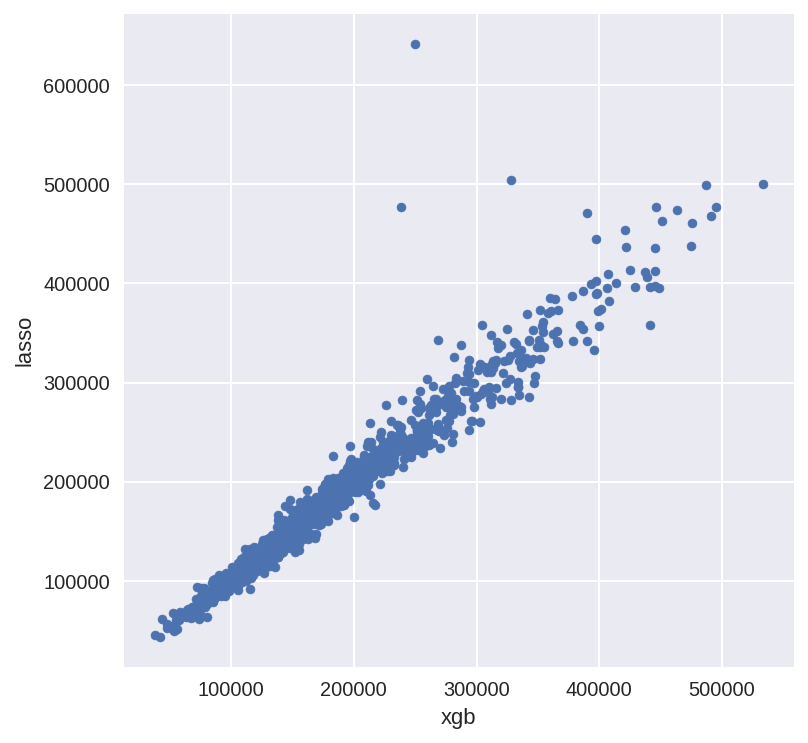

In [27]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [28]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [29]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [30]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [31]:
X_train = StandardScaler().fit_transform(X_train)

In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [33]:
X_tr.shape

(1095, 288)

In [34]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ..., 
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [35]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  app.launch_new_instance()


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [37]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/10
1095/1095 [==============================] - 0s - loss: 147.0313 - val_loss: 149.9484
Epoch 2/10
1095/1095 [==============================] - 0s - loss: 144.6278 - val_loss: 150.5536
Epoch 3/10
1095/1095 [==============================] - 0s - loss: 142.8769 - val_loss: 151.4110
Epoch 4/10
1095/1095 [==============================] - 0s - loss: 141.3150 - val_loss: 152.4455
Epoch 5/10
1095/1095 [==============================] - 0s - loss: 139.8918 - val_loss: 153.7267
Epoch 6/10
1095/1095 [==============================] - 0s - loss: 138.4870 - val_loss: 155.0268
Epoch 7/10
1095/1095 [==============================] - 0s - loss: 137.1905 - val_loss: 156.3740
Epoch 8/10
1095/1095 [==============================] - 0s - loss: 135.9163 - val_loss: 157.8431
Epoch 9/10
1095/1095 [==============================] - 0s - loss: 134.6428 - val_loss: 159.4450
Epoch 10/10
1095/1095 [==============================] - 0s - loss: 133.3451 - v

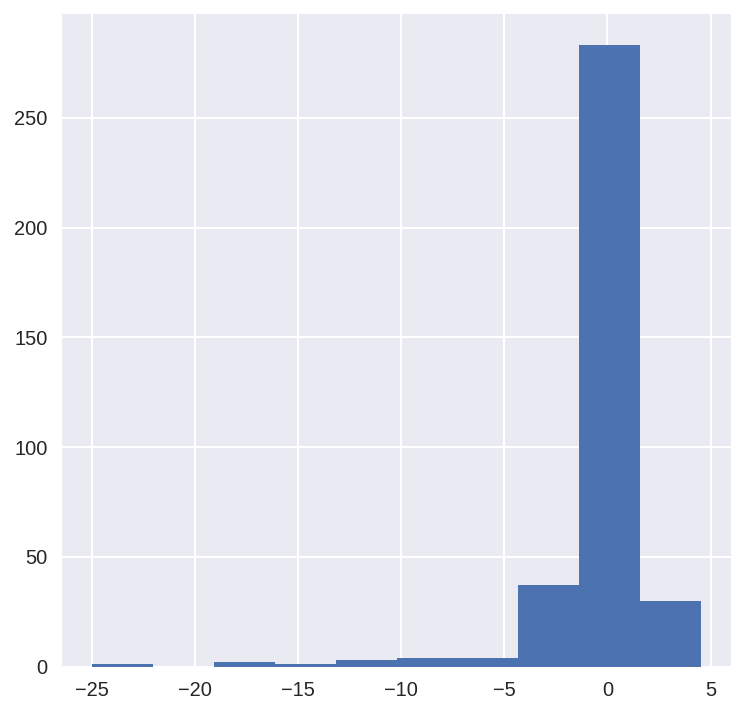

In [38]:
pd.Series(model.predict(X_val)[:,0]).hist()